In [328]:
import os
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, layers, Input

In [329]:
og_df = pd.read_csv('labels.csv')

In [330]:
og_df['label'].value_counts()

label
2    1426
3     930
1     708
Name: count, dtype: int64

In [331]:
df = og_df.copy()

In [332]:
df['label'] = df['label'] - df['label'].min()

In [333]:
# Image directory and resize config
img_dir = 'C:/Users/User/dimaag/png_images'
IMG_SIZE = (224, 224)

In [334]:
# Preload all images and labels into NumPy arrays
images = []
labels = []

for _, row in df.iterrows():
    img_path = os.path.join(img_dir, row['filename'])
    image = load_img(img_path, target_size=IMG_SIZE)
    image = img_to_array(image) / 255.0
    label = row['label']
    images.append(image)
    labels.append(label)

In [335]:
# Convert to NumPy arrays first
images = np.array(images, dtype=np.float32)
labels = np.array(labels, dtype=np.int32)

In [336]:
#Now split the NumPy arrays
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

In [337]:
#Convert to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val   = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_val   = tf.convert_to_tensor(y_val, dtype=tf.int32)

In [338]:
df['label'].value_counts()

label
1    1426
2     930
0     708
Name: count, dtype: int64

In [339]:
custom_model = Sequential([
    Input(shape=(224, 224, 3)),  #Explicit input layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

In [340]:
custom_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [341]:
custom_model.fit(X_train, y_train, epochs=12, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/12
77/77 ━━━━━━━━━━━━━━━━━━━━ 38s 470ms/step - accuracy: 0.6223 - loss: 1.1612 - val_accuracy: 0.8450 - val_loss: 0.3372
Epoch 2/12
77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 481ms/step - accuracy: 0.8882 - loss: 0.2642 - val_accuracy: 0.9021 - val_loss: 0.2213
Epoch 3/12
77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 480ms/step - accuracy: 0.9584 - loss: 0.1097 - val_accuracy: 0.9217 - val_loss: 0.1757
Epoch 4/12
77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 476ms/step - accuracy: 0.9834 - loss: 0.0518 - val_accuracy: 0.9201 - val_loss: 0.2204
Epoch 5/12
77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 475ms/step - accuracy: 0.9892 - loss: 0.0342 - val_accuracy: 0.9152 - val_loss: 0.2218
Epoch 6/12
77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 480ms/step - accuracy: 0.9916 - loss: 0.0293 - val_accuracy: 0.9282 - val_loss: 0.2697
Epoch 7/12
77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 478ms/step - accuracy: 0.9918 - loss: 0.0245 - val_accuracy: 0.9299 - val_loss: 0.2075
Epoch 8/12
77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 483ms/step - accuracy: 0.9933 - loss: 0.0218 - val_accu

In [342]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [343]:
# Get predicted probabilities
y_pred_probs = custom_model.predict(X_val)

# Get predicted class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert y_val to NumPy array if it's a Tensor
y_true = y_val.numpy() if isinstance(y_val, tf.Tensor) else y_val

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


In [344]:
print("\nClassification Report (Custom CNN):")
class_names = ["Meningioma", "Glioma", "Pituitary"]
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report (Custom CNN):
              precision    recall  f1-score   support

  Meningioma       0.92      0.87      0.90       142
      Glioma       0.94      0.96      0.95       285
   Pituitary       0.99      0.99      0.99       186

    accuracy                           0.95       613
   macro avg       0.95      0.94      0.95       613
weighted avg       0.95      0.95      0.95       613



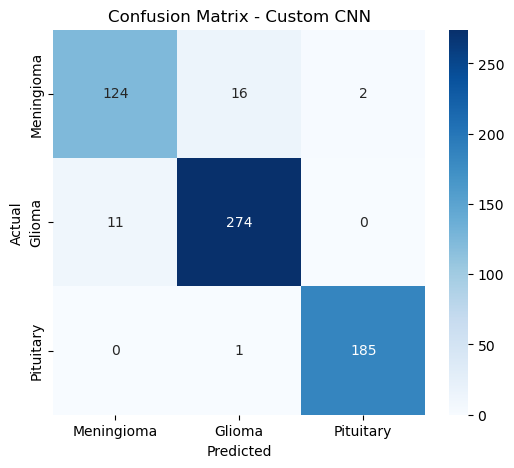

In [345]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Custom CNN")
plt.show()

In [346]:
loss, accuracy = custom_model.evaluate(X_val, y_val, verbose=0)
print(f"Custom CNN Accuracy: {accuracy:.4f}")

Custom CNN Accuracy: 0.9511


In [369]:
custom_model.save('final_custom_model.keras')